# Leave one framework out ablation study
- Plot figures related to leave one framework out experiments.

In [1]:
import glob
import os
from math import ceil 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from zeobind.src.utils.utils import setup_mpl
setup_mpl() 

In [2]:
cm = 1/2.54  # centimeters in inches

def save_mpl_fig(fig, basename, ending='.pdf', dpi=300):
    fig.savefig(basename + ending, bbox_inches='tight', dpi=dpi)

def format_axs(
    axs,
    xtick_size,
    ytick_size,
    spines_width,
    xlabel,
    ylabel,
    xlabel_size,
    ylabel_size,
    limits=None,
    tick_width=2, 
    tick_size=6, 
    xticks=None,
    yticks=None,
):
    # Set tick labels
    if xticks is not None:
        axs.set_xticks(xticks)
    if yticks is not None:
        axs.set_yticks(yticks)

    axs.tick_params(axis="x", which="major", labelsize=xtick_size)
    axs.tick_params(axis="y", which="major", labelsize=ytick_size)
    axs.xaxis.set_tick_params(width=tick_width, size=tick_size)
    axs.yaxis.set_tick_params(width=tick_width, size=tick_size)

    # axs.tick_params(axis='both', which='minor="something", labelsize=8)
    for axis in ["top", "bottom", "left", "right"]:
        axs.spines[axis].set_linewidth(spines_width)

    axs.set_xlabel(xlabel, fontsize=xlabel_size)
    axs.set_ylabel(ylabel, fontsize=ylabel_size)
    
    if not limits:
        return axs
    if "x" in limits.keys():
        axs.set_xlim(limits["x"])
    if "y" in limits.keys():
        axs.set_ylim(limits["y"])
    
    return axs

def get_cb(fig, sc, axs, label, ticks=None, linewidth=2, tickwidth=2, labelsize=18, labelpad=20):
    '''Get colorbar'''
    cb = fig.colorbar(sc, ax=axs)
    cb.set_label(label, fontsize=labelsize)
    cb.outline.set_linewidth(linewidth)
    if ticks is not None:
        cb.set_ticks(ticks)
    cb.ax.tick_params(width=tickwidth)
    cb.ax.tick_params(labelsize=labelsize)
    # pad
    cb.ax.xaxis.labelpad = labelpad
    return cb

def get_legend(
    fig,
    bbox_to_anchor=(0.5, 1.1),
    fontsize=15,
    loc="upper center",
    ncol=2,
    axs=None,
    format_handles=False,
    legend_colors=None,
    linewidth=2,
    edgecolor="k",
    put_where="fig",
):
    '''Get legend.'''
    positions = {"fig": fig, "axs": axs}
    legend = positions[put_where].legend(
        fontsize=fontsize,
        loc=loc,
        bbox_to_anchor=bbox_to_anchor,
        ncol=ncol,
        frameon=False,
    )

    if format_handles:
        for idx, handle in enumerate(legend.legendHandles):
            handle.set_color(legend_colors[idx])
            handle.set_linewidth(linewidth)
            handle.set_edgecolor(edgecolor)

    return legend
    
def get_color_values(num_colors, c="viridis"):
    '''Get a list of color values from a colormap'''
    cmap = plt.cm.get_cmap(c)
    color_values = [cmap(i) for i in np.linspace(0, 1, num_colors)]
    return color_values

def draw_parity(axs, xlimits, ylimits, lw=1):
    '''Draw a parity line on a plot'''
    limits = [min(xlimits[0], ylimits[0]), max(xlimits[1], ylimits[1])]
    axs.plot(limits, limits, "k--", lw=lw)
    return axs

def get_gridsize(y_min, y_max, x_min, x_max, hex_length):
    """Given the length of the x and y axis, as well as length of the hexagon, return the appropriate gridsize input."""
    ny = ceil( (y_max - y_min) / hex_length)
    nx = ceil( (x_max - x_min) / hex_length * np.sqrt(3))
    # nx = ceil(np.sqrt(3) * ny)
    return (nx, ny)

# Read predictions

In [5]:
truth = pd.read_csv("../data/datasets/training_data/training_data.csv", index_col=0)

In [7]:
l1fo_pred_dir = "../data/publication/l1fo/predictions"

In [9]:
l1fo_op_dir = "../data/publication/l1fo"
os.makedirs(l1fo_op_dir, exist_ok=True)

In [4]:
fws = ["cha",  "eri",  "fau",  "kfi",  "lta",  "mfi"]

# Color by std dev average

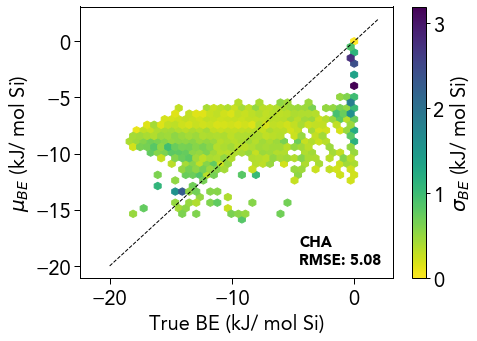

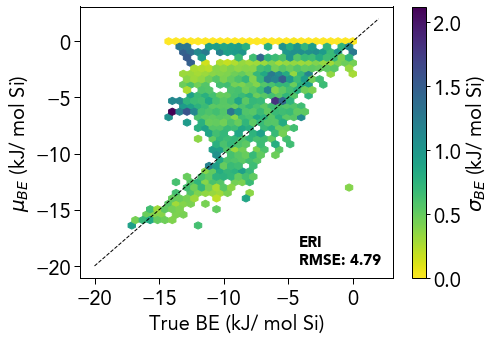

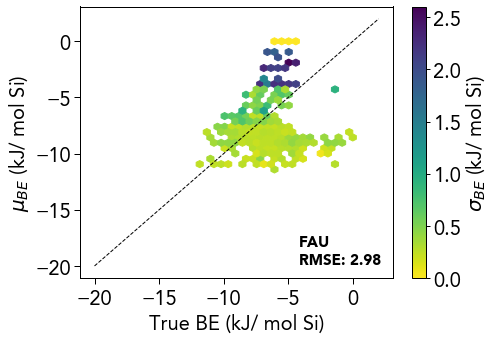

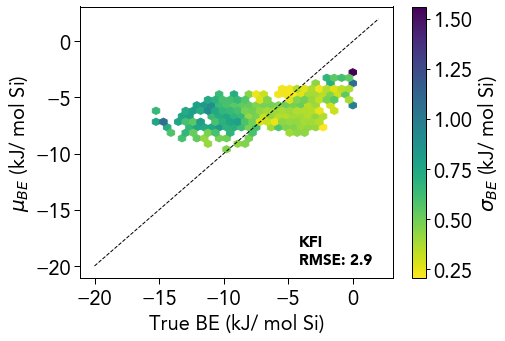

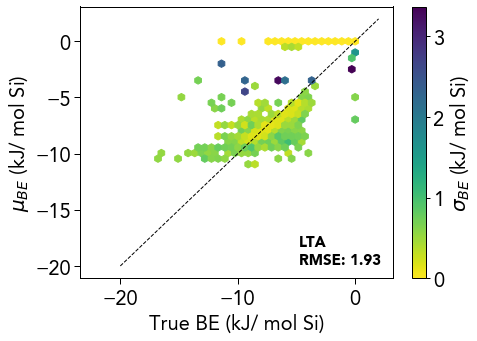

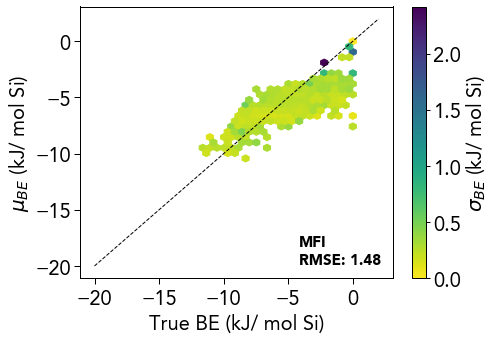

In [10]:
for fw in fws:

    truth_fw = truth[
        (truth['Zeolite'] == fw.upper())
    ].set_index('SMILES')['Binding (SiO2)']

    mean_files = glob.glob(f"{l1fo_pred_dir}/{fw}/formatted_be/*mean*csv")
    std_files = glob.glob(f"{l1fo_pred_dir}/{fw}/formatted_be/*std*csv")

    preds_mean = [pd.read_csv(f) for f in mean_files]
    preds_std = [pd.read_csv(f) for f in std_files]

    preds_mean = pd.concat(preds_mean)
    preds_mean = preds_mean.drop_duplicates('SMILES').set_index('SMILES')
    preds_std = pd.concat(preds_std)
    preds_std = preds_std.drop_duplicates('SMILES').set_index('SMILES')

    preds_mean = preds_mean.loc[truth_fw.index][fw.upper()]
    preds_std = preds_std.loc[truth_fw.index][fw.upper()]

    fig, axs = plt.subplots(figsize=(7, 5)) 

    x = truth_fw.values
    y = preds_mean.values
    c = preds_std.values
    rmse = np.sqrt(mean_squared_error(x,y))

    limits= dict(x=(-20, 2), y=(-20, 2))
    gridsize = get_gridsize(min(y), max(y), min(x), max(x), 1)
    kwargs = dict(mincnt=1, cmap='viridis_r', gridsize=gridsize, C=c, reduce_C_function=np.mean)
    sc = axs.hexbin(x, y, **kwargs)
    cb = get_cb(fig, sc, axs, "$\sigma_{BE}$ (kJ/ mol Si)", None, 1, 1, 20, 20)
    axs = format_axs(axs, 20, 20, 1, "True BE (kJ/ mol Si)", "$\mu_{BE}$ (kJ/ mol Si)", 20, 20, limits=None, tick_width=1, tick_size=6, bold_axs=False, xticks=None, yticks=None,
    )
    axs = draw_parity(axs, limits['x'], limits['y'], lw=1)
    axs.annotate(f"{fw.upper()}\nRMSE: {round(rmse,2)}", size=15, weight='bold', xy=(0.7, 0.05), xycoords='axes fraction');

    save_mpl_fig(fig, f"{l1fo_op_dir}/l1fo_{fw}", ending='.pdf', dpi=300)
    save_mpl_fig(fig, f"{l1fo_op_dir}/l1fo_{fw}", ending='.svg', dpi=300)